In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, DataStructs, rdFingerprintGenerator, PandasTools, rdFingerprintGenerator, MACCSkeys
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.ML.Cluster import Butina
from chembl_webresource_client.new_client import new_client
from pathlib import Path

In [2]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

In [3]:
cwd = Path.cwd()
cwd

WindowsPath('d:/Visual Studio 2019/Python/Epam/TechOpenCADD/01_Compound_Data_Acc_ChEMBL/sve_data')

Uniprot id for EGFR kinease from https://www.uniprot.org/

In [4]:
uniprot_id = 'P00533'

Configuring client's parameters

In [5]:
target_api = new_client.target
molecule_api = new_client.molecule
bioactivity_api = new_client.activity

I realy don't know what are names of the available columns. So, I will download data for the first target into pd.Series object to see what are avaliable columns. From list of available columns I will choose columns of interest.

In [6]:
proba_target = target_api.get(
    target_components__accession=uniprot_id
)
proba_df = pd.Series(proba_target[0])
proba_df

cross_references      [{'xref_id': 'P00533', 'xref_name': None, 'xre...
organism                                                   Homo sapiens
pref_name                        Epidermal growth factor receptor erbB1
species_group_flag                                                False
target_chembl_id                                              CHEMBL203
target_components     [{'accession': 'P00533', 'component_descriptio...
target_type                                              SINGLE PROTEIN
tax_id                                                             9606
dtype: object

I will use 'target_chembl_id', 'pref_name', 'organism' and 'target_type' columns

Preparing api options and sownloading target data for P00533 into data frame

In [7]:
target_info = target_api.get(
    target_components__accession='P00533'
).only(
    'target_chembl_id', 'pref_name', 'organism', 'target_type'
)

In [8]:
target_info[0]

{'organism': 'Homo sapiens',
 'pref_name': 'Epidermal growth factor receptor erbB1',
 'target_chembl_id': 'CHEMBL203',
 'target_type': 'SINGLE PROTEIN'}

In [9]:
targets_df = pd.DataFrame(target_info)

Available targets

In [10]:
targets_df

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
2,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
3,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
4,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


We will use first record's target_chembl_id as target molecule (CHEMBL203)

In [11]:
target = targets_df['target_chembl_id'][0]
target

'CHEMBL203'

Again, I don't know what are avaliable columns for activities. I will download data for first activity into pd.Series to see what kind of data is intersting

In [12]:
proba_bio = bioactivity_api.filter(target_chembl_id=target)
proba_df = pd.Series(proba_bio[0])
print(proba_df)

action_type                                                               None
activity_comment                                                          None
activity_id                                                              32260
activity_properties                                                         []
assay_chembl_id                                                   CHEMBL674637
assay_description            Inhibitory activity towards tyrosine phosphory...
assay_type                                                                   B
assay_variant_accession                                                   None
assay_variant_mutation                                                    None
bao_endpoint                                                       BAO_0000190
bao_format                                                         BAO_0000357
bao_label                                                single protein format
canonical_smiles             Cc1cc(C)c(/C=C2\C(=O)Nc

I wll filter database using 'target_chembl_id', 'assay_type', 'type' and 'relation'.
I will use 'activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id',  'type', 'standard_units', 'relation', 'standard_value', 'target_chembl_id', 'target_organism' for columns of interest.

Resulting data frame is saved under name 'bio_CHEMBL203.csv' and loaded if already exists. If it doesn't exists, data is downloaded and saved under that name.

In [13]:
if not (cwd / f'bio_{target}.csv').exists():
    bioactivity = bioactivity_api.filter(
        target_chembl_id=target, assay_type='B', type='IC50', relation__in=['<', '<=', '=']
    ).only(
        'activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id',  'type', 'standard_units', 'relation', 'standard_value', 'target_chembl_id', 'target_organism'
    )
    bioactivity_df = pd.DataFrame(bioactivity)
    bioactivity_df.to_csv(f'bio_{target}.csv')
else:
    bioactivity_df = pd.read_csv(f'bio_{target}.csv', index_col=0)

In [14]:
bioactivity_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.170
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.300
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.000
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50,uM,3000.000


In [15]:
bioactivity_df.shape

(11485, 13)

Let's drop nan and duplicates

In [16]:
bioactivity_df.dropna(axis='index', how='any', inplace=True)
bioactivity_df.drop_duplicates(subset='molecule_chembl_id', keep='first', inplace=True)
bioactivity_df.shape

(7552, 13)

For units can be various units

In [17]:
bioactivity_df['units'].unique()

array(['uM', 'nM', 'M', "10'1 ug/ml", 'ug ml-1', "10'-1microM", "10'1 uM",
       "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM", '/uM', "10'-6g/ml", 'mM',
       'umol/L', 'nmol/L', 'nmol'], dtype=object)

We will drop columns 'units' and 'value'

In [18]:
bioactivity_df.drop(columns=['units', 'value'], inplace=True)

In [19]:
bioactivity_df.shape

(7552, 11)

Different units for 'standard units' columns. We will keep only those with nM units

In [20]:
bioactivity_df['standard_units'].unique()

array(['nM', 'ug.mL-1', '/uM'], dtype=object)

In [21]:
bioactivity_df = bioactivity_df[bioactivity_df['standard_units'] == 'nM']
bioactivity_df.shape

(7493, 11)

We will rename columns 'standard units' and 'standard value' to 'units' and 'IC50

In [22]:
bioactivity_df.rename(columns={'standard_value': 'IC50', 'standard_units': 'units'}, inplace=True)

Let's reset index

In [23]:
bioactivity_df.reset_index(drop=True, inplace=True)

In [24]:
bioactivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         7493 non-null   int64  
 1   assay_chembl_id     7493 non-null   object 
 2   assay_description   7493 non-null   object 
 3   assay_type          7493 non-null   object 
 4   molecule_chembl_id  7493 non-null   object 
 5   relation            7493 non-null   object 
 6   units               7493 non-null   object 
 7   IC50                7493 non-null   float64
 8   target_chembl_id    7493 non-null   object 
 9   target_organism     7493 non-null   object 
 10  type                7493 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 644.1+ KB


In [25]:
molecules_list = bioactivity_df['molecule_chembl_id'].to_list()
molecules_list[:10]

['CHEMBL68920',
 'CHEMBL69960',
 'CHEMBL137635',
 'CHEMBL306988',
 'CHEMBL66879',
 'CHEMBL77085',
 'CHEMBL443268',
 'CHEMBL76979',
 'CHEMBL76589',
 'CHEMBL76904']

Let's see which columns are avaliable for molecules

In [26]:
proba_molecules = molecule_api.filter(
    molecule_chembl_id=molecules_list[0]
)
# print(proba_molecules)
proba_df = pd.DataFrame(proba_molecules)
proba_df

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chemical_probe,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,helm_notation,indication_class,inorganic_flag,max_phase,molecule_chembl_id,molecule_hierarchy,molecule_properties,molecule_structures,molecule_synonyms,molecule_type,natural_product,oral,orphan,parenteral,polymer_flag,pref_name,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_flag
0,[],-1,None,0,None,0,-1,[],False,None,-1,None,None,-1,None,CHEMBL68920,"{'active_chembl_id': 'CHEMBL68920', 'molecule_...","{'alogp': '4.45', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'Cc1cc(C)c(/C=C2\C(=O)Nc3...,[],Small molecule,0,False,-1,False,0,None,-1,MOL,False,False,None,None,None,None,False


In [27]:
proba_df.columns

Index(['atc_classifications', 'availability_type', 'biotherapeutic',
       'black_box_warning', 'chebi_par_id', 'chemical_probe', 'chirality',
       'cross_references', 'dosed_ingredient', 'first_approval',
       'first_in_class', 'helm_notation', 'indication_class', 'inorganic_flag',
       'max_phase', 'molecule_chembl_id', 'molecule_hierarchy',
       'molecule_properties', 'molecule_structures', 'molecule_synonyms',
       'molecule_type', 'natural_product', 'oral', 'orphan', 'parenteral',
       'polymer_flag', 'pref_name', 'prodrug', 'structure_type',
       'therapeutic_flag', 'topical', 'usan_stem', 'usan_stem_definition',
       'usan_substem', 'usan_year', 'withdrawn_flag'],
      dtype='object')

We are interestd in 'molecule_chembl_id' and 'molecule_structures' columns

This data frame cannot be saves because 'molecule_structures' column is made of dicts

In [28]:

molecules = molecule_api.filter(
    molecule_chembl_id__in=molecules_list
).only(
    'molecule_chembl_id', 'molecule_structures'
)
molecules_df = pd.DataFrame(molecules)
molecules_df.shape

(7493, 2)

In [29]:
molecules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   molecule_chembl_id   7493 non-null   object
 1   molecule_structures  7486 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


Let's drop nan values first

In [30]:
molecules_df.dropna(axis='index', how='any', inplace=True)
molecules_df.shape

(7486, 2)

We are interested in 'canonical_sniles' key in 'molecule_structures' column (which is column made of dicts)

In [31]:
molecules_df['molecule_structures'][0]

{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23',
 'molfile': '\n     RDKit          2D\n\n 22 25  0  0  0  0  0  0  0  0999 V2000\n   -0.4750   -0.2417    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5750    0.3583    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4750   -1.4792    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5750    1.6000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5333    0.3583    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6292   -0.2417    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5750   -2.0875    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4750    2.2083    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5333    1.6000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6292   -1.4792    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6292    2.2083    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5333   -2.0875    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\

From this columns let's extract values for 'canonical_smiles' keys. If the key is missing or None, we append None to the smiles_list. After that, we drop 'molecule_structures' column, drop duplicates and nan values

In [32]:
smiles_list = []
for _, row in molecules_df.iterrows():
    try:
        smiles_list.append(row['molecule_structures']['canonical_smiles'])
    except (KeyError, TypeError):
        smiles_list.append(None)
molecules_df['smiles'] = smiles_list

In [33]:
molecules_df.shape

(7486, 3)

In [34]:
molecules_df.head(3)

,molecule_chembl_id,molecule_structures,smiles
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...,COc1cc2c(cc1OC)Nc1ncn(C)c(=O)c1C2


In [35]:
molecules_df.drop(columns='molecule_structures', inplace=True)
molecules_df.shape

(7486, 2)

In [36]:
molecules_df.dropna(axis='index', how='any', inplace=True)
molecules_df.shape

(7486, 2)

In [37]:
molecules_df.drop_duplicates(subset='smiles', keep='first', inplace=True)
molecules_df.drop_duplicates(subset='molecule_chembl_id', keep='first', inplace=True)
molecules_df.shape

(7486, 2)

In [38]:
molecules_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7486 entries, 0 to 7492
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   molecule_chembl_id  7486 non-null   object
 1   smiles              7486 non-null   object
dtypes: object(2)
memory usage: 433.5+ KB


Now, we will merge bioactivity_df data frame with molecules_df data frame on molecule_chembl_id column. First we will select columns of interest from bioactivity_df

In [39]:
bioactivity_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [40]:
cols = ['molecule_chembl_id', 'IC50', 'units']

In [41]:
data = pd.merge(left=bioactivity_df[cols], right=molecules_df, on='molecule_chembl_id')

In [42]:
bioactivity_df.shape, molecules_df.shape, data.shape

((7493, 11), (7486, 2), (7486, 4))

In [43]:
data.head(3)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12


Range of IC50 values is too wide, so we will use pIC50 values instead. These values are in nano mols (nM), so we have to scale with 1e-09 factor

In [44]:
data['IC50'].min(), data['IC50'].max()

(0.003, 55000000.0)

In [45]:
data['pIC50'] = data['IC50'].apply(lambda x: -np.log10(x * 1e-09))
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


Let's sort by activity and reset index

In [46]:
data.sort_values(by='pIC50', ascending=False, inplace=True)

In [47]:
data.reset_index(drop=True, inplace=True)

We can visualize it with hist plot

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

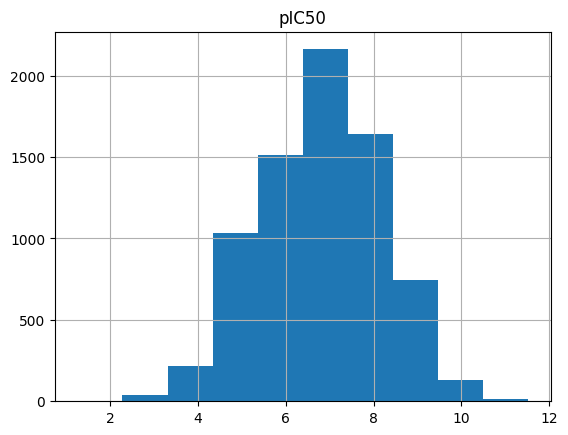

In [48]:
data.hist(column='pIC50')

Let's save it as csv for future uses

In [49]:
data.to_csv(f'data_{target}.csv')

Let's calculate properties Lipinski's rule of 5 (moleculat weight, numbers of hydrogen donors and acceptors and log if ocatnol-water coefficient)

As first step, we will have to calculater mols from smiles

In [50]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles')

In [51]:
data.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...


whole list of descriptors

In [52]:
Descriptors.descList

[('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('SPS', <function rdkit.Chem.SpacialScore.SPS(mol, normalize=True)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('Ma

Descriptors' calculation
this can also be achived with datamol which gives data frame which can be merged with data data frame

In [53]:
data['molecular_weight'] = data['ROMol'].apply(Descriptors.ExactMolWt)
data['n_hbd'] = data['ROMol'].apply(Descriptors.NumHDonors)
data['n_hba'] = data['ROMol'].apply(Descriptors.NumHAcceptors)
data['logp'] = data['ROMol'].apply(Descriptors.MolLogP)

In [54]:
data.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hbd,n_hba,logp
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,349.021459,1,3,5.2891
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,343.043258,1,5,3.5969
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,387.058239,1,5,4.9333


To pass Lipinski's rule of 5, molecule cannot have more than one fail:

MolWy <= 500

n_hba <= 10

n_hbd <= 5

logp <= 5

In [55]:
col_lipiski = list(data.columns)[-4:]
col_lipiski

['molecular_weight', 'n_hbd', 'n_hba', 'logp']

In [56]:
passed = []
for _, row in data.iterrows():
    zbir = sum([row['molecular_weight'] <= 500, row['n_hba'] <= 10, row['n_hbd'] <= 5, row['logp'] <= 5]) >= 3
    passed.append(zbir)
data['passed'] = passed

In [57]:
data['passed'].unique()

array([ True, False])

In [58]:
data.head(10)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hbd,n_hba,logp,passed
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,349.021459,1,3,5.2891,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,343.043258,1,5,3.5969,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,387.058239,1,5,4.9333,True
3,CHEMBL5270693,0.008,nM,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(C(=O)Oc2cccc...,11.096910,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,562.269239,2,8,6.1267,False
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,339.011957,2,4,4.0122,True
5,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,329.027607,2,5,3.5726,True
6,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,353.027607,1,5,4.0226,True
7,CHEMBL174426,0.025,nM,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,353.027607,1,5,4.0226,True
8,CHEMBL29197,0.025,nM,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,359.026939,1,5,4.1531,True
9,CHEMBL5288888,0.027,nM,C=CC(=O)N1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2O...,10.568636,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF2...,512.162661,1,7,4.8894,True


In [59]:
data.shape

(7486, 11)

In [60]:
data = data[data['passed']]
data.shape

(5873, 11)

In [61]:
data.reset_index(drop=True, inplace=True)

In [62]:
data.shape

(5873, 11)

'ROMol' column must be deleted before saving .csv file because it has to be calculated again after loading file. Creating a copy of data frame with dropped column

In [63]:
data = data.drop(columns='ROMol')

In [64]:
data.to_csv('data_Lipinski_CHEMBL203.csv')

Let's remove PAINS

In [65]:
pains_params = FilterCatalogParams()
pains_params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains_catalog = FilterCatalog(pains_params)

In [66]:
pains_matches = []
clean_indices = []
for index, row in data.iterrows():
    molecule = Chem.MolFromSmiles(row['smiles'])
    match = pains_catalog.GetFirstMatch(molecule)
    if match:
        pains_matches.append({
            'chembl_id': row['molecule_chembl_id'],
            'Mol': molecule,
            'description': match.GetDescription()
        })
    else:
        clean_indices.append(index)

In [67]:
pains_matches = pd.DataFrame(pains_matches)
pains_matches.head()

,chembl_id,Mol,description
0,CHEMBL5271803,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF3...,hzone_pyrrol(64)
1,CHEMBL5220645,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF3...,anil_di_alk_G(9)
2,CHEMBL93032,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF3...,catechol_A(92)
3,CHEMBL5191510,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF3...,mannich_A(296)
4,CHEMBL4858583,<rdkit.Chem.rdchem.Mol object at 0x0000019BDF3...,azo_A(324)


What are most common pains in this case?

In [68]:
pains_matches.groupby(by='description', as_index=True).size().sort_values(ascending=False)

description
anil_di_alk_A(478)       185
catechol_A(92)            87
mannich_A(296)            48
ene_cyano_A(19)           39
quinone_A(370)            38
azo_A(324)                32
ene_one_ene_A(57)         29
indol_3yl_alk(461)        11
hzone_phenol_A(479)        7
ene_five_het_B(90)         5
ene_five_het_D(46)         5
anil_di_alk_B(251)         5
anil_no_alk(40)            4
ene_six_het_D(1)           4
imine_one_isatin(189)      3
hzone_phenol_B(215)        3
anil_di_alk_G(9)           2
cyano_imine_B(17)          2
anil_di_alk_C(246)         2
hzone_pipzn(79)            2
hzone_pyrrol(64)           2
imine_one_A(321)           1
amino_acridine_A(46)       1
hzone_furan_A(6)           1
hzone_anil_di_alk(35)      1
ene_cyano_E(1)             1
anthranil_one_A(38)        1
thio_urea_D(8)             1
dtype: int64

In [69]:
data_clean = data.loc[clean_indices].copy()

In [70]:
data_clean.shape

(5351, 10)

In [71]:
len(data), len(data_clean) + len(pains_matches)

(5873, 5873)

In [72]:
data_clean.reset_index(drop=True, inplace=True)

In [73]:
data_clean.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,1,3,5.2891,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True


In [74]:
help(FilterCatalogParams.FilterCatalogs)

Help on class FilterCatalogs in module rdkit.Chem.rdfiltercatalog:

class FilterCatalogs(Boost.Python.enum)
 |  Method resolution order:
 |      FilterCatalogs
 |      Boost.Python.enum
 |      builtins.int
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  ALL = rdkit.Chem.rdfiltercatalog.FilterCatalogs.ALL
 |  
 |  BRENK = rdkit.Chem.rdfiltercatalog.FilterCatalogs.BRENK
 |  
 |  CHEMBL = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL
 |  
 |  CHEMBL_BMS = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL_BMS
 |  
 |  CHEMBL_Dundee = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL_Dunde...
 |  
 |  CHEMBL_Glaxo = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL_Glaxo
 |  
 |  CHEMBL_Inpharmatica = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL...
 |  
 |  CHEMBL_LINT = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL_LINT
 |  
 |  CHEMBL_MLSMR = rdkit.Chem.rdfiltercatalog.FilterCatalogs.CHEMBL_MLSMR
 |  
 |  CHEMBL_SureChEMBL = rdkit.Chem.rdfiltercat

In [75]:
brenk_params = FilterCatalogParams()
brenk_params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk_catalog = FilterCatalog(brenk_params)

In [76]:
brenk_matches = []
clean_indices = []
for index, row in data_clean.iterrows():
    molecule = Chem.MolFromSmiles(row['smiles'])
    has_match = False
    matches = brenk_catalog.GetMatches(molecule)
    if matches:
        for match in matches:
            brenk_matches.append({
                'chembl_id': row['molecule_chembl_id'],
                'mol': molecule,
                'description': match.GetDescription()
            })
        has_match = True
    else:
        clean_indices.append(index)
 

In [77]:
brenk_matches = pd.DataFrame(brenk_matches)

What are most common Brenk's unwanted substructures

In [78]:
brenk_matches.groupby('description').size().sort_values(ascending=False)

description
Michael_acceptor_1             1394
Aliphatic_long_chain            594
Oxygen-nitrogen_single_bond     520
triple_bond                     313
imine_1                         204
                               ... 
peroxide                          1
cyanamide                         1
Sulfonic_acid_2                   1
thioester                         1
triphenyl_methyl-silyl            1
Length: 56, dtype: int64

In [79]:
len(data_clean)

5351

Remove unwanted Brenk's substructures

In [80]:
data_clean = data_clean.loc[clean_indices]

In [81]:
len(data_clean)

2584

Reset index and save clean data

In [82]:
data_clean.reset_index(drop=True, inplace=True)
data_clean.to_csv('data_clean_Lipinski_CHEMBL203.csv')

In [83]:
data_clean.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed
0,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True
2,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.0122,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.5726,True
4,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,353.027607,1,5,4.0226,True


Let's make some clusters with MACCS fingerprints and Tanimoto distances

First make mols and calclulate fingerprints

In [84]:
mols = data_clean['smiles'].apply(Chem.MolFromSmiles)
maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
len(maccs), len(maccs[0])

(2584, 167)

In [85]:
def get_dissimilarities(fng_list):
    dissimil = []
    for i in range(1, len(fng_list)):
        simil = DataStructs.BulkTanimotoSimilarity(fng_list[i], fng_list[:i])
        dissimil.extend([1 - sim for sim in simil])
    return dissimil

In [86]:
def get_clusters(fng_list, cut_off=0.2):
    dissimil_matrix = get_dissimilarities(fng_list)
    clusters = Butina.ClusterData(dissimil_matrix, len(fng_list), cut_off, isDistData=True)
    # We must sort clusters by length, from bigest to smallest
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Let's cluster it with cut_off=0.3

In [87]:
clusters = get_clusters(maccs, cut_off=0.3)
len(clusters)

214

We have 214 clusters in this case

Lengths of 10 largest clusters

In [88]:
for cls in clusters[:10]:
    print(len(cls))

480
219
182
136
105
84
68
57
57
53


Graphical view using bars

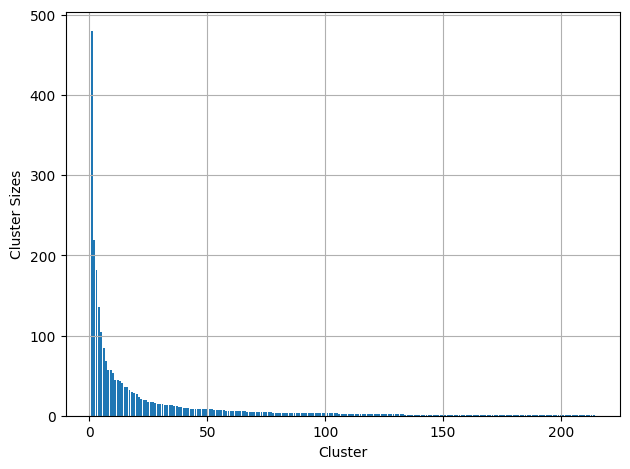

In [89]:

plt.bar(x=np.arange(1, len(clusters) + 1), height=[len(cls) for cls in clusters])
plt.xlabel('Cluster')
plt.ylabel('Cluster Sizes')
plt.grid()
plt.tight_layout()

Let's examine clusters for cut_off in range [0, 0.9] to find best cut_off value

In [90]:
def show_clusters(fingerprints):
    br = 0
    cut_offs = np.arange(0.0, 1.0, 0.1)
    fig, ax = plt.subplots(10, 1, figsize=(10, 15))
    for cut_off in cut_offs:
        cls = get_clusters(fingerprints, cut_off=cut_off)
        ax[br].bar(x=np.arange(1, len(cls) + 1), height=[len(c) for c in cls])
        ax[br].set_xlabel('Clusters')
        ax[br].set_ylabel('Cluster Sizes')
        ax[br].set_title(f'{len(cls)} clusters, cut_off = {cut_off:.2f}')
        br += 1
    plt.tight_layout()

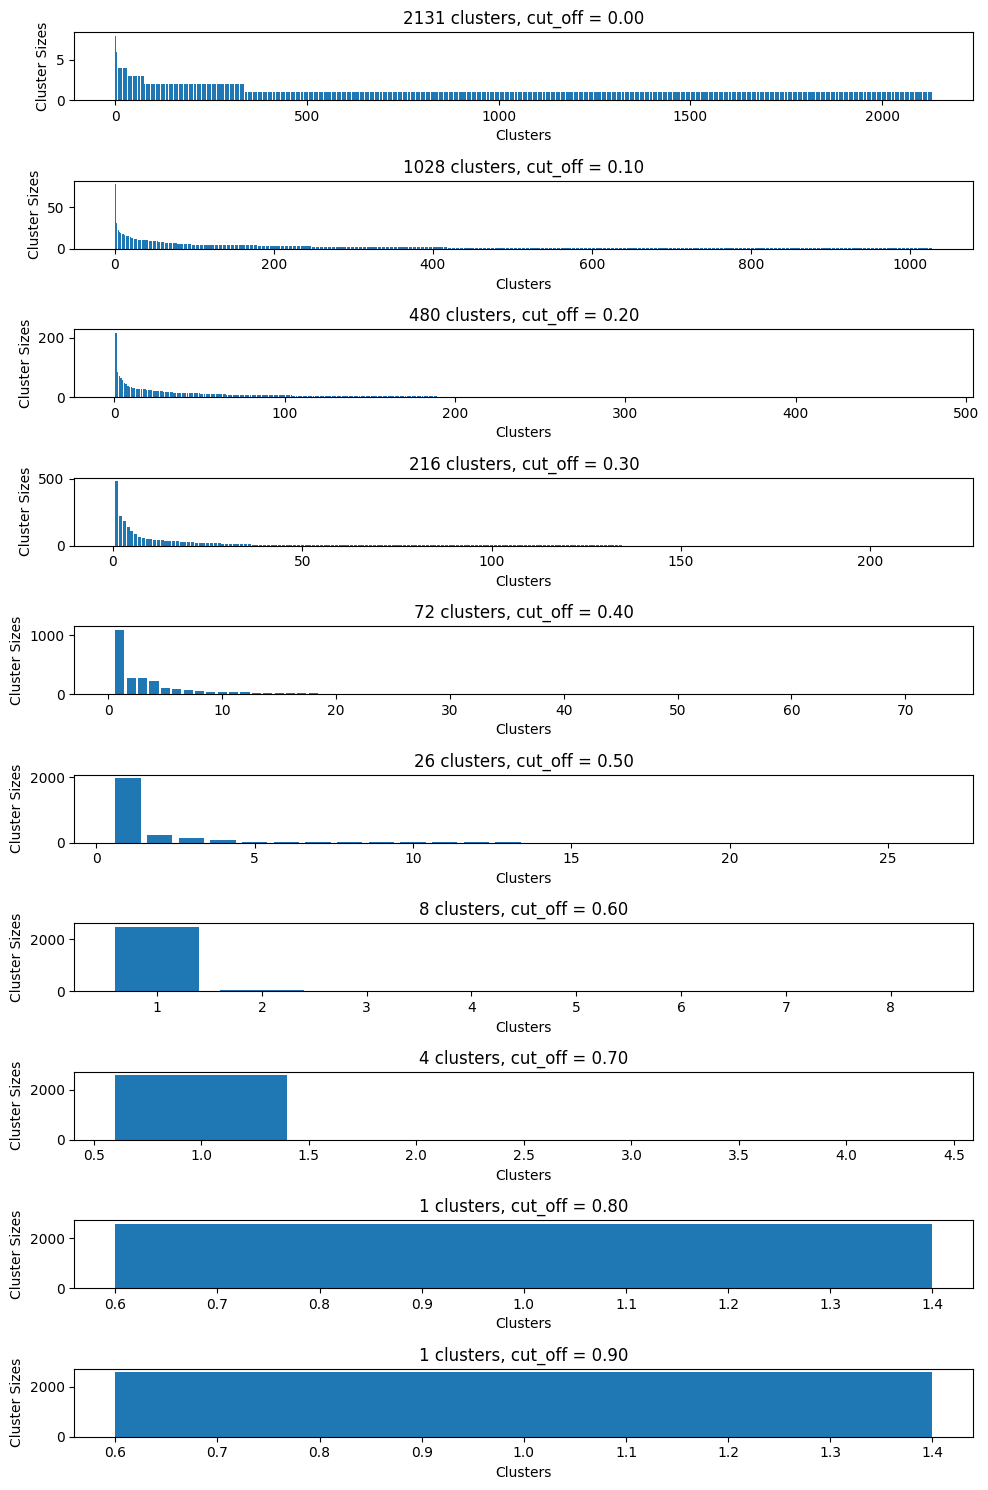

In [91]:
show_clusters(maccs)

Let's add column with cluster numbers to the data frame

In [92]:
clusters[75]

(2016, 997, 1616, 1893, 2002)

In [93]:
cluster_list = [-1] * len(data_clean)
for i in range(len(clusters)):
    for index in clusters[i]:
        cluster_list[index] = i
data_clean['MACCS_clusters'] = cluster_list

First ten molecules from first cluster

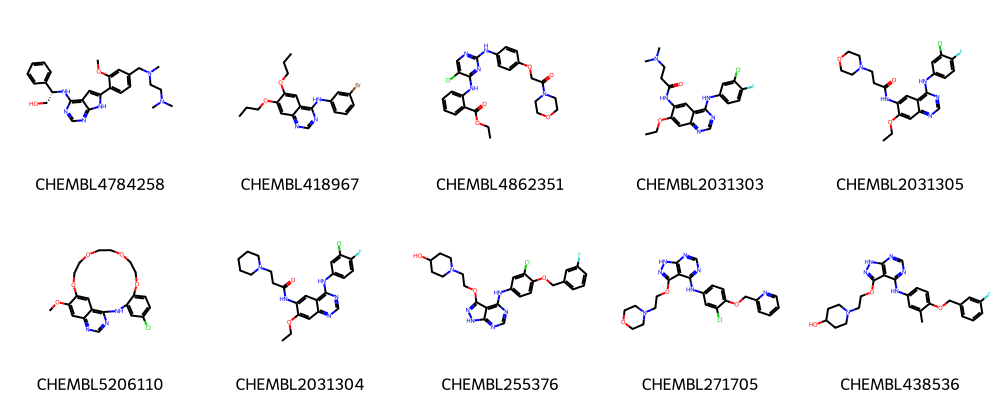

In [94]:
first = data_clean[data_clean['MACCS_clusters'] == 0][:10]
Draw.MolsToGridImage(
    list(first['smiles'].apply(Chem.MolFromSmiles)),
    legends=first['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

First ten molecules from second cluster

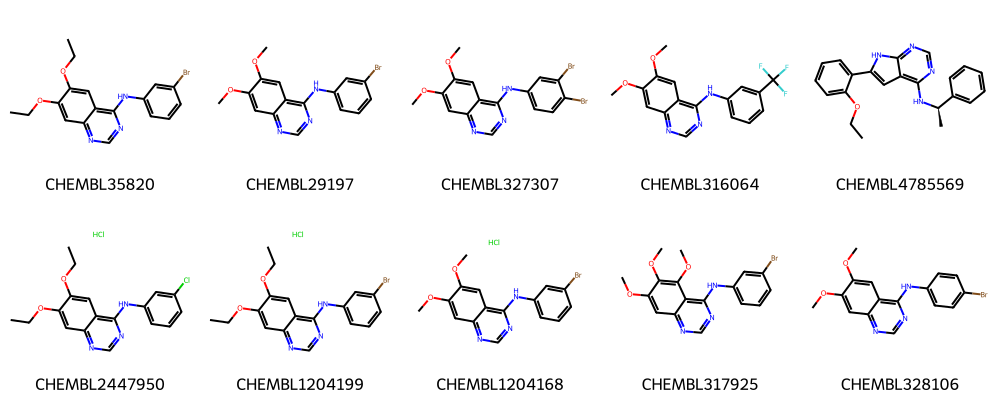

In [95]:
second = data_clean[data_clean['MACCS_clusters'] == 1][:10]
Draw.MolsToGridImage(
    list(second['smiles'].apply(Chem.MolFromSmiles)),
    legends=second['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

First ten molecules from third cluster

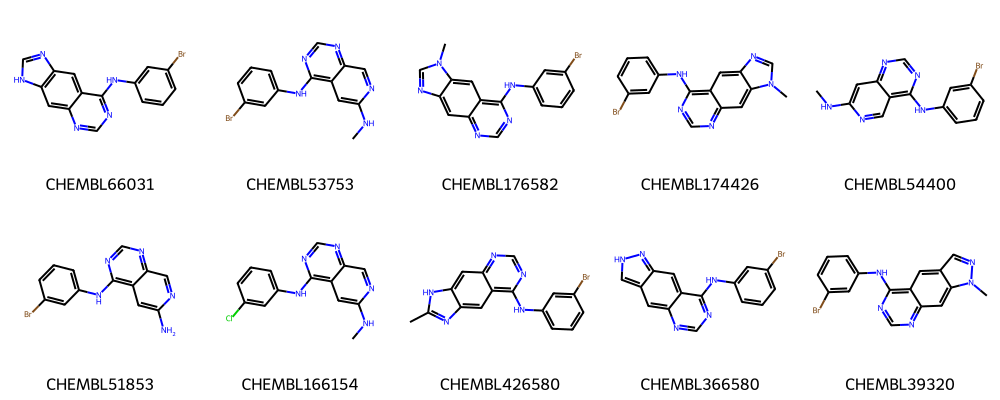

In [96]:
third = data_clean[data_clean['MACCS_clusters'] == 2][:10]
Draw.MolsToGridImage(
    third['smiles'].apply(Chem.MolFromSmiles),
    legends=third['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

First molecules from first ten clusters

In [97]:
ones = data_clean.drop_duplicates(subset='MACCS_clusters', keep='first').sort_values(by='MACCS_clusters')[:10]
ones

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters
11,CHEMBL4784258,0.100,nM,COc1cc(CN(C)CCN(C)C)ccc1-c1cc2c(N[C@H](CO)c3cc...,10.000000,474.274324,3,7,3.77240,True,0
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.93330,True,1
2,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.01220,True,2
24,CHEMBL4164805,0.200,nM,COc1cc(CO)ccc1-c1cc2c(N[C@H](CO)c3ccccc3)ncnc2...,9.698970,390.169191,4,6,3.27130,True,3
142,CHEMBL121954,1.000,nM,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,9.000000,352.083937,4,6,4.19910,True,4
12,CHEMBL941,0.110,nM,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,9.958607,493.259009,2,7,4.59032,True,5
440,CHEMBL4280817,9.000,nM,O=C1CSC(N2N=C(c3ccncc3)CC2c2ccc(Br)cc2)=N1,8.045757,399.999344,0,5,3.62460,True,6
75,CHEMBL4776751,0.500,nM,COc1cc(C(N)=O)ccc1-c1cc2c(N[C@H](CO)c3ccccc3)n...,9.301030,403.164440,4,6,2.87790,True,7
78,CHEMBL2031299,0.510,nM,O=C(CCN1CCOCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,9.292430,455.095687,2,6,3.79670,True,8
19,CHEMBL165864,0.190,nM,OCCNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,9.721246,359.038172,3,6,2.93510,True,9


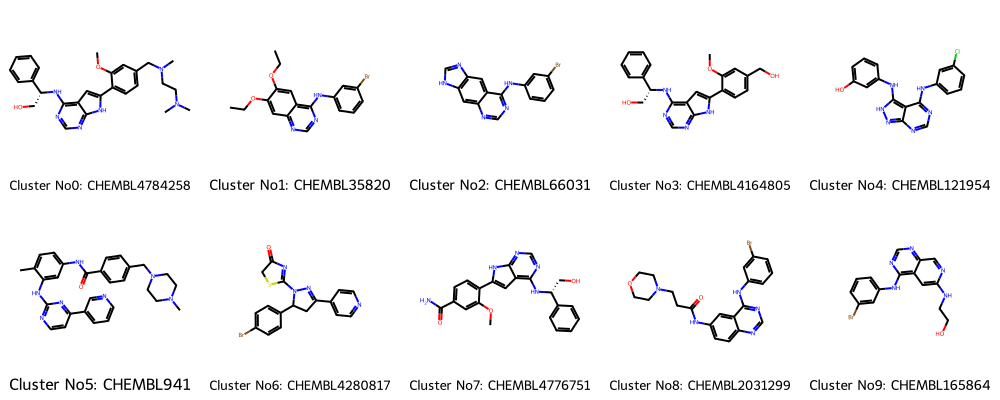

In [98]:
Draw.MolsToGridImage(
    ones['smiles'].apply(Chem.MolFromSmiles),
    legends=[f"Cluster No{row['MACCS_clusters']}: {row['molecule_chembl_id']}" for _, row in ones.iterrows()],
    molsPerRow=5
)

Let's use ECPF4 fingerprints with Tanimoto similiarity

In [99]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
ecpf4 = [morgan_gen.GetFingerprint(mol) for mol in mols]

In [100]:
len(ecpf4), len(ecpf4[0])

(2584, 2048)

Let's see how the clusters change with cut_off

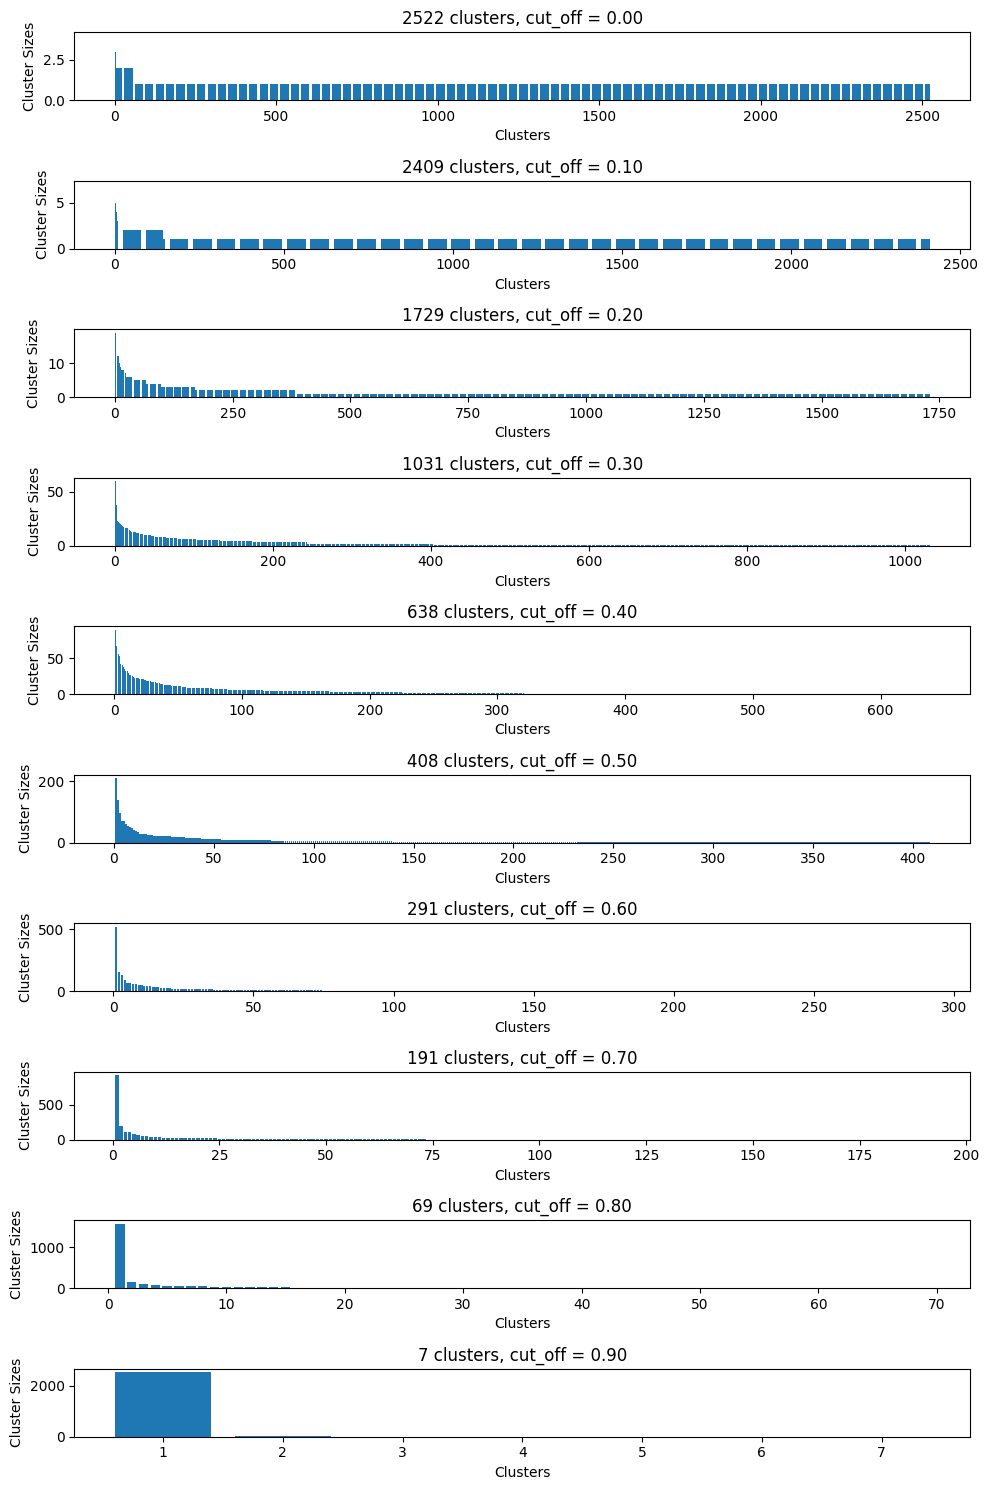

In [101]:
show_clusters(ecpf4)

Let it be cut_off = 0.4

In [102]:
clusters = get_clusters(ecpf4, cut_off=0.4)

In [103]:
len(clusters)

638

Sizes of first 10 clusters

In [104]:
for i in range(10):
    print(len(clusters[i]))

90
67
56
53
42
41
38
35
33
32


In [105]:
cluster_list = [-1] * len(data_clean)
for i in range(len(clusters)):
    for mol_num in clusters[i]:
        cluster_list[mol_num] = i
data_clean['ECFP4_clusters'] = cluster_list

In [106]:
data_clean.head(30)

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
0,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.59690,True,46,1
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.93330,True,1,1
2,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.01220,True,2,1
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.57260,True,2,1
4,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,353.027607,1,5,4.02260,True,2,1
5,CHEMBL174426,0.025,nM,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,353.027607,1,5,4.02260,True,2,1
6,CHEMBL29197,0.025,nM,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,359.026939,1,5,4.15310,True,1,1
7,CHEMBL327307,0.072,nM,COc1cc2ncnc(Nc3ccc(Br)c(Br)c3)c2cc1OC,10.142668,436.937451,1,5,4.91560,True,1,1
8,CHEMBL53428,0.090,nM,CN(C)c1cc2ncnc(Nc3cccc(Br)c3)c2cn1,10.045757,343.043258,1,5,3.59690,True,20,1
9,CHEMBL4760328,0.100,nM,CCOc1ccccc1-c1cc2c(N[C@H](CCO)c3ccccc3)ncnc2[nH]1,10.000000,388.189926,3,5,4.55920,True,13,28


In [107]:
first = data_clean[data_clean['ECFP4_clusters'] == 0][:10]
first

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
243,CHEMBL215786,3.0,nM,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCC1CCN(C)CC1,8.522879,430.157182,1,6,4.89510,True,0,0
771,CHEMBL3907215,50.0,nM,COc1cc2c(Nc3ccc(Cl)c(C)c3)ncnc2cc1OCC1CN(C)CCO1,7.301030,428.161518,1,7,4.05322,True,0,0
773,CHEMBL3937598,50.0,nM,CCOC(=O)C(C)N1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)...,7.301030,534.143675,1,9,4.72000,True,0,0
774,CHEMBL3923013,50.0,nM,COCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc2...,7.301030,492.133111,1,8,4.41480,True,0,0
775,CHEMBL3952315,50.0,nM,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCC1CN(C(C)...,7.301030,476.138196,1,7,5.17680,True,0,0
776,CHEMBL3983179,50.0,nM,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCC1CN(C)CCN1C,7.301030,461.138530,1,7,4.31340,True,0,0
778,CHEMBL3947408,50.0,nM,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCC1CN(C(C)...,7.301030,490.153846,1,7,5.56690,True,0,0
779,CHEMBL3986301,50.0,nM,COCCN1CCCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc...,7.301030,506.148761,1,8,4.80490,True,0,0
780,CHEMBL3978177,50.0,nM,COC(=O)CCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)...,7.301030,520.128025,1,9,4.33150,True,0,0
781,CHEMBL3912287,50.0,nM,COc1cc2c(Nc3cccc(Br)c3C)ncnc2cc1OCC1CN(C)CCO1,7.301030,472.111003,1,7,4.16232,True,0,0


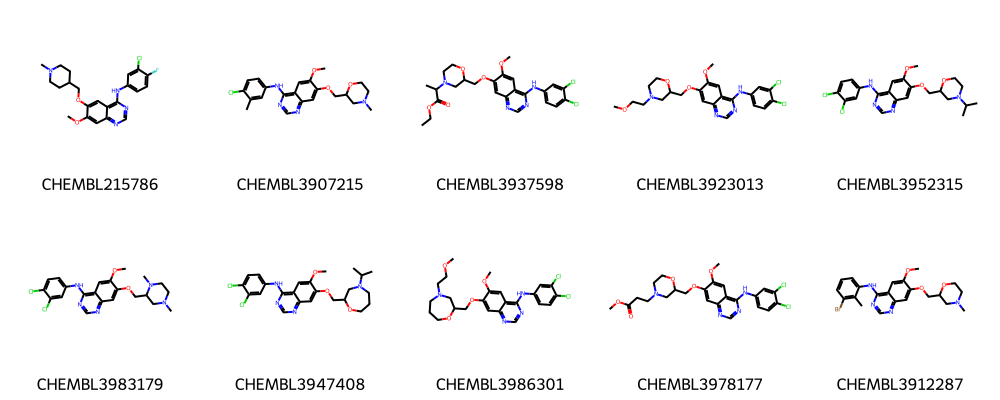

In [108]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(sm) for sm in first['smiles'].to_list()],
    legends=first['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

In [109]:
second = data_clean[data_clean['ECFP4_clusters'] == 1][:10]
second

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
0,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True,46,1
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True,1,1
2,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.0122,True,2,1
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.5726,True,2,1
4,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,353.027607,1,5,4.0226,True,2,1
5,CHEMBL174426,0.025,nM,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,353.027607,1,5,4.0226,True,2,1
6,CHEMBL29197,0.025,nM,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,359.026939,1,5,4.1531,True,1,1
7,CHEMBL327307,0.072,nM,COc1cc2ncnc(Nc3ccc(Br)c(Br)c3)c2cc1OC,10.142668,436.937451,1,5,4.9156,True,1,1
8,CHEMBL53428,0.090,nM,CN(C)c1cc2ncnc(Nc3cccc(Br)c3)c2cn1,10.045757,343.043258,1,5,3.5969,True,20,1
13,CHEMBL54400,0.130,nM,CNc1cc2ncnc(Nc3cccc(Br)c3)c2cn1,9.886057,329.027607,2,5,3.5726,True,2,1


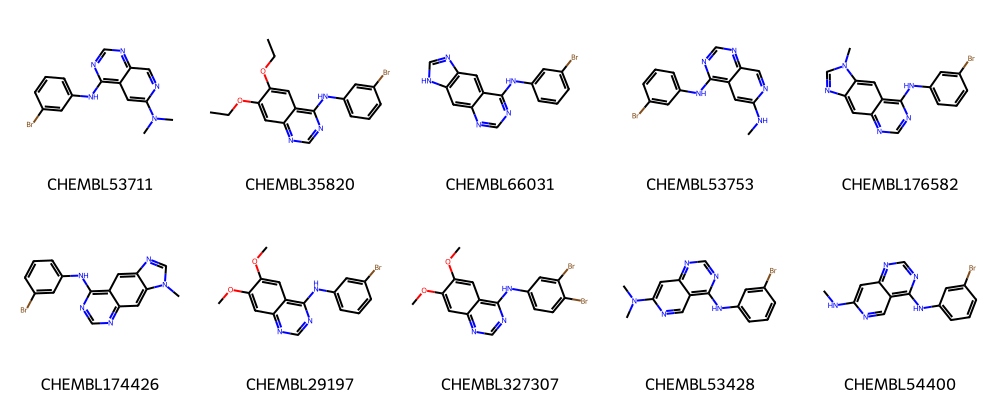

In [110]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(sm) for sm in second['smiles'].to_list()],
    legends=second['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

In [111]:
third = data_clean[data_clean['ECFP4_clusters'] == 2][:10]
third

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
354,CHEMBL1645474,6.0,nM,NC1CCN(Cc2ccn3ncnc(Nc4cccc(Br)c4)c23)CC1,8.221849,400.101107,2,6,3.15850,True,9,2
446,CHEMBL1645473,9.0,nM,NC1CCN(Cc2ccn3ncnc(Nc4cccc(Cl)c4)c23)CC1,8.045757,356.151622,2,6,3.04940,True,12,2
473,CHEMBL1645476,10.0,nM,NC1CCN(Cc2ccn3ncnc(Nc4ccc(F)c(Cl)c4)c23)CC1,8.000000,374.142201,2,6,3.18850,True,12,2
546,CHEMBL248114,19.0,nM,Cc1cncc(Cn2ncc3cc(Nc4ncnn5ccc(CN6CCC(N)CC6)c45...,7.721246,467.254592,2,9,3.49742,True,9,2
560,CHEMBL1645470,20.0,nM,Cc1cccc(Nc2ncnn3ccc(CN4CCC(N)CC4)c23)c1,7.698970,336.206245,2,6,2.70442,True,9,2
613,CHEMBL233325,26.0,nM,O[C@H]1CNCCN(Cc2ccn3ncnc(Nc4ccc5c(cnn5Cc5cccc(...,7.585027,486.229186,3,9,2.77610,True,8,2
652,CHEMBL394057,30.0,nM,O=C(O)COCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,7.522879,446.150267,2,8,3.61120,True,9,2
675,CHEMBL1645472,32.0,nM,NC1CCN(Cc2ccn3ncnc(Nc4cccc(F)c4)c23)CC1,7.494850,340.181173,2,6,2.53510,True,12,2
684,CHEMBL392273,33.0,nM,Fc1cccc(Cn2ncc3cc(Nc4ncnn5ccc(CN6CCCNCC6)c45)c...,7.481486,470.234271,2,8,3.80530,True,12,2
695,CHEMBL248108,35.0,nM,NC1CCN(Cc2ccn3ncnc(Nc4ccc5c(cnn5Cc5cccc(F)c5)c...,7.455932,470.234271,2,8,3.93310,True,12,2


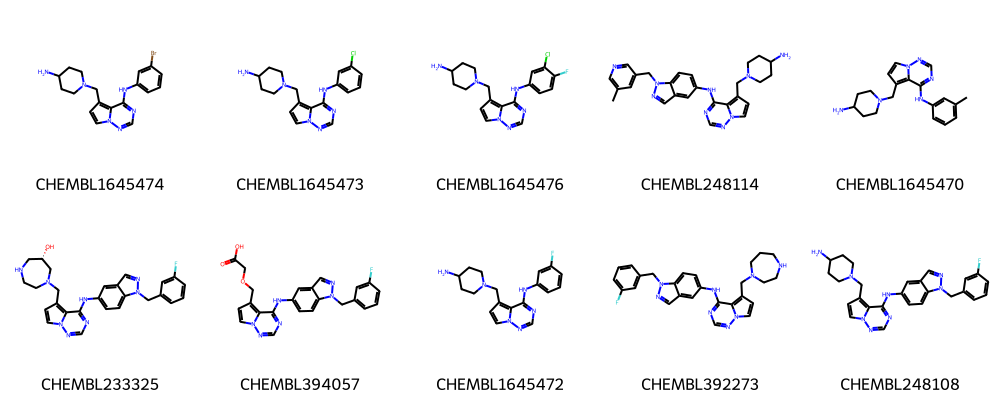

In [112]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(sm) for sm in third['smiles'].to_list()],
    legends=third['molecule_chembl_id'].to_list(),
    molsPerRow=5
)

In [113]:
ones = data_clean.drop_duplicates(subset='ECFP4_clusters', keep='first').sort_values(by='ECFP4_clusters')[:10]
ones

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
243,CHEMBL215786,3.000,nM,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCC1CCN(C)CC1,8.522879,430.157182,1,6,4.89510,True,0,0
0,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.59690,True,46,1
354,CHEMBL1645474,6.000,nM,NC1CCN(Cc2ccn3ncnc(Nc4cccc(Br)c4)c23)CC1,8.221849,400.101107,2,6,3.15850,True,9,2
1036,CHEMBL1242662,88.000,nM,CC(C)n1nc(-c2ccc3cc(O)ccc3c2)c2c(N)ncnc21,7.055517,319.143310,2,6,3.51520,True,4,3
440,CHEMBL4280817,9.000,nM,O=C1CSC(N2N=C(c3ccncc3)CC2c2ccc(Br)cc2)=N1,8.045757,399.999344,0,5,3.62460,True,6,4
174,CHEMBL3623279,1.500,nM,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1N1CCOCC1,8.823909,388.110232,1,6,4.01110,True,0,5
32,CHEMBL2031303,0.270,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)CCN(C)C,9.568636,431.152431,2,6,4.45480,True,0,6
17,CHEMBL592617,0.170,nM,N#CCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,9.769551,381.022522,2,5,3.98808,True,15,7
39,CHEMBL4743998,0.300,nM,C[C@@H](Nc1ncnc2[nH]c(-c3ccc(NS(C)(=O)=O)cc3)c...,9.522879,407.141596,3,5,4.16950,True,11,8
72,CHEMBL3758582,0.500,nM,COc1ccc(C(=O)NCCN(C)C)cc1-c1cc2c(N[C@H](C)c3cc...,9.301030,475.204196,2,7,4.83140,True,29,9


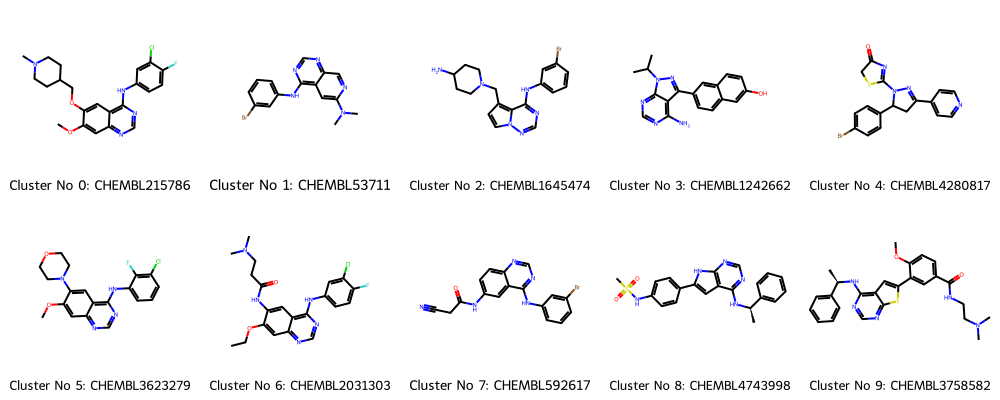

In [114]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(sm) for sm in ones['smiles'].to_list()],
    legends=[f"Cluster No {row['ECFP4_clusters']}: {row['molecule_chembl_id']}" for _, row in ones.iterrows()],
    molsPerRow=5
)

In [115]:
data_clean.head(2)

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,MACCS_clusters,ECFP4_clusters
0,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True,46,1
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True,1,1


In [116]:
data_clean.to_csv('data_clusters.csv')